# Search-Based Test Generation

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

## The Test Data Generation Problem

The problem we will consider in this chapter is the following: Given an entry point to a program (a function), we want to find values for the parameters of this function such that the execution of the function reaches a particular point in the program. In other words, we aim to find a test input to the program that covers a target statement. We will then generalise this problem to finding test inputs to cover _all_ statements in the program.

Assume we are aiming to test the following function under test:

In [2]:
def test_me(x, y):
    if x == 2 * (y + 1):
        return True
    else:
        return False

The `test_me` function has two input parameters, `x`and `y`, and it returns `True` or `False` depending on how the parameters relate:

In [3]:
test_me(10, 10)

False

In [4]:
test_me(22, 10)

True

In order to address the test generation problem as a search problem, we need to decide on an encoding, and derive appropriate search operators. It is possible to use bitvectors like we did on previous problems; however, a simpler interpretation of the parameters of a function is a list of the actual parameters. That is, we encode a test input as a list of parameters; we will start by assuming that all parameters are numeric.

The representation for inputs of this function is lists of length two, one element for `x` and one for `y`. As numeric values in Python are unbounded, we need to decide on some finite bounds for these values, e.g.:

In [5]:
MAX=1000
MIN=-MAX

For generating inputs we can now uniformly sample in the range (MIN, MAX). The length of the vector shall be the number of parameters of the function under test. Rather than hard coding such a parameter, we can also make our approach generalise better by using inspection to determine how many parameters the function under test has:

In [6]:
from inspect import signature
sig = signature(test_me)
num_parameters = len(sig.parameters)
num_parameters

2

As usual, we will define the representation implicitly using a function that produces random instances.

In [7]:
def get_random_individual():
    return [random.randint(MIN, MAX) for _ in range(num_parameters)]

In [8]:
get_random_individual()

[399, -748]

We need to define search operators matching this representation. To apply local search, we need to define the neighbourhood. For example, we could define one upper and one lower neighbour for each parameter:

- `x-1, y`
- `x+1, y`
- `x, y+1`
- `x, y-1`

In [9]:
def get_neighbours(individual):
    neighbours = []
    for p in range(len(individual)):
        if individual[p] > MIN:
            neighbour = individual[:]
            neighbour[p] = individual[p] - 1
            neighbours.append(neighbour)
        if individual[p] < MAX:
            neighbour = individual[:]
            neighbour[p] = individual[p] + 1
            neighbours.append(neighbour)
            
    return neighbours

In [10]:
x = get_random_individual()
x

[-851, 190]

In [11]:
get_neighbours(x)

[[-852, 190], [-850, 190], [-851, 189], [-851, 191]]

Before we can apply search, we also need to define a fitness function.  Suppose that we are interested in covering the `True` branch of the if-condition in the `test_me()` function, i.e. `x == 2 * (y + 1)`.

How close is a given input tuple for this function from reaching the target branch? Let's consider an arbitrary point in the search space, e.g. `(274, 153)`. The if-condition compares the following values:

In [12]:
x = 274
y = 153
x, 2 * (y + 1)

(274, 308)

In order to make the branch true, both values need to be the same. Thus, the more they differ, the further we are away from making the comparison true, and the less they differ, the closer we are from making the comparison true. Thus, we can quantify "how false" the comparison is by calculating the difference between `x` and `2 * (y + 1)`. Thus, we can calculate this distance as `abs(x - 2 * (y + 1))`:

In [13]:
def calculate_distance(x, y):
    return abs(x - 2 * (y + 1))

In [14]:
calculate_distance(274, 153)

34

We can use this distance value as our fitness function, since we can nicely measure how close we are to an optimal solution. Note, however, that "better" doesn't mean "bigger" in this case; the smaller the distance the better. This is not a problem, since any algorithm that can maximize a value can also be made to minimize it instead.

For each value in the search space of integer tuples, this distance value defines the elevation in our search landscape. Since our example search space is two-dimensional, the search landscape is three-dimensional and we can plot it to see what it looks like:

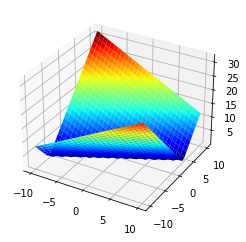

In [15]:
x = np.outer(np.linspace(-10, 10, 30), np.ones(30))
y = x.copy().T
z = calculate_distance(x, y)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0);

The optimal values, i.e. those that make the if-condition true, have fitness value 0 and can be clearly seen at the bottom of the plot. The further away from the optimal values, the higher elevated the points in the search space.

This distance can serve as our fitness function if we aim to cover the true branch of the program in our example:

In [16]:
def get_fitness(individual):
    x = individual[0]
    y = individual[1]
    return abs(x - 2 * (y + 1))

We can now use any local search algorithm we have defined previously, with only one modification: In the prior examples where we applied local search we were always maximising fitness values; now we are minimising, so a hillclimber, for example, should only move to neighbours with _smaller_ fitness values:

In [17]:
max_steps = 10000
fitness_values = []

Let's use a steepest ascent hillclimber:

In [18]:
def hillclimbing():

    current = get_random_individual()
    fitness = get_fitness(current)
    best = current[:]
    best_fitness = fitness
    print(f"Starting at fitness {best_fitness}: {current}")

    step = 0
    while step < max_steps and best_fitness > 0:
        neighbours = [(x, get_fitness(x)) for x in get_neighbours(current)]
        best_neighbour, neighbour_fitness = min(neighbours, key=lambda i: i[1])
        step += len(neighbours)        
        fitness_values.extend([best_fitness] * len(neighbours))
        if neighbour_fitness < fitness:
            current = best_neighbour
            fitness = neighbour_fitness
            if fitness < best_fitness:
                best = current[:]
                best_fitness = fitness
                #print(f"Iteration {step}, fitness {best_fitness}: {best}")
        else:
            # Random restart if no neighbour is better
            current = get_random_individual()
            fitness = get_fitness(current)
            step += 1
            if fitness < best_fitness:
                #print(f"Iteration {step}, fitness {best_fitness}: {best}")
                best = current[:]
                best_fitness = fitness
            fitness_values.append(best_fitness)


    print(f"Solution fitness after {step} fitness evaluations: {best_fitness}: {best}")
    return best

In [19]:
fitness_values = []
hillclimbing()

Starting at fitness 435: [-867, -217]
Solution fitness after 872 fitness evaluations: 0: [-866, -434]


[-866, -434]

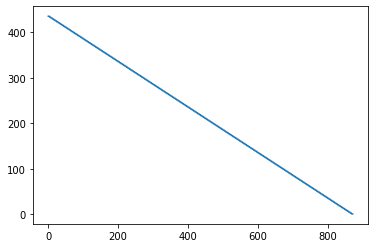

In [20]:
plt.plot(fitness_values)

Since there are no local optima, the hillclimber will easily find the solution, even without restarts. However, this can take a while, in particular if we use a larger input space:

In [21]:
MAX=100000
MIN=-MAX

Starting at fitness 56478: [-54858, -55669]
Solution fitness after 10000 fitness evaluations: 51478: [-54858, -53169]


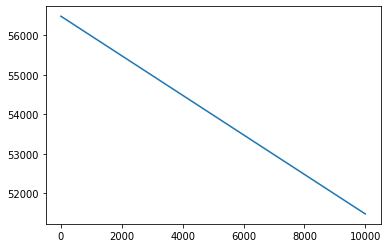

In [22]:
fitness_values = []
hillclimbing()
plt.plot(fitness_values)

Unless the randomly chosen initial point is already close to an optimal solution, the hillclimber is going to be hopeless in moving through the search space within a reasonable number of iterations.

## Alternating Variable Method

The search problem represented by the `test_me` function has an easy fitness landscape with no local optima. However, it still takes quite long to reach the optimum, depending on where the random starting point lies in the search space. This is because the neighbourhood for real program inputs can be quite large, depending on the number of parameters, and even just the search space for each parameter individually can already be very large. In our example we restricted `MAX` and `MIN` to a very narrow range, but imagine doing this for 32 bit integers. Both these problems are addressed with an adapted version of our hillclimber known as the _Alternating Variable Method_, which differs from the hillclimber in two ways: 
1. Rather than considering the neighbourhood of all input parameters at once, we apply search to each parameter individually in turn
2. Rather than taking only small steps of size 1, we allow larger jumps in the search space.

Let's first consider the second aspect, larger jumps in the search space. The idea is to apply a _pattern_ search where we first decide on a direction in the search space to move, and then apply increasingly larger steps in that direction as long as the fitness improves. We only consider a single parameter, thus the "direction" simply refers to whether one increases or decreases this value. The function thus takes (1) the individual on which to perform the search, (2) a particular parameter we are considering, (3) the direction of the search, and (4) the starting fitness values. 

In [23]:
def pattern_search(individual, parameter, direction, fitness):
    print(f"-> {individual}, direction {direction}, fitness {fitness}")

    individual[parameter] = individual[parameter] + direction
    new_fitness = get_fitness(individual)
    if new_fitness < fitness:
        fitness_values.append(new_fitness)
        return pattern_search(individual, parameter, 2 * direction, new_fitness)
    else:
        # If fitness is not better we overshot. Undo last move, and return
        fitness_values.append(fitness)
        individual[parameter] = individual[parameter] - direction
        return fitness

For example, let's assume `y` is a large value(1000), and `x` is considerably smaller. For our example function, the optimal value for `x` would thus be at 2200. Applying the search to `x` we thus need to move in the positive direction (`1`), and the function will do this with increasing steps until it "overshoots".

In [24]:
x = [0, 1000]
f = get_fitness(x)
pattern_search(x, 0, 1, get_fitness(x))

-> [0, 1000], direction 1, fitness 2002
-> [1, 1000], direction 2, fitness 2001
-> [3, 1000], direction 4, fitness 1999
-> [7, 1000], direction 8, fitness 1995
-> [15, 1000], direction 16, fitness 1987
-> [31, 1000], direction 32, fitness 1971
-> [63, 1000], direction 64, fitness 1939
-> [127, 1000], direction 128, fitness 1875
-> [255, 1000], direction 256, fitness 1747
-> [511, 1000], direction 512, fitness 1491
-> [1023, 1000], direction 1024, fitness 979
-> [2047, 1000], direction 2048, fitness 45


45

If `x` is larger than `y` we would need to move in the other direction, and the search does this until it undershoots the target of 2200:

In [25]:
x = [10000, 1000]
f = get_fitness(x)
pattern_search(x, 0, -1, get_fitness(x))

-> [10000, 1000], direction -1, fitness 7998
-> [9999, 1000], direction -2, fitness 7997
-> [9997, 1000], direction -4, fitness 7995
-> [9993, 1000], direction -8, fitness 7991
-> [9985, 1000], direction -16, fitness 7983
-> [9969, 1000], direction -32, fitness 7967
-> [9937, 1000], direction -64, fitness 7935
-> [9873, 1000], direction -128, fitness 7871
-> [9745, 1000], direction -256, fitness 7743
-> [9489, 1000], direction -512, fitness 7487
-> [8977, 1000], direction -1024, fitness 6975
-> [7953, 1000], direction -2048, fitness 5951
-> [5905, 1000], direction -4096, fitness 3903
-> [1809, 1000], direction -8192, fitness 193


193

The AVM algorithm applies the pattern search as follows:
1. Start with the first parameter
2. Probe the neighbourhood of the parameter to find the direction of the search
3. Apply pattern search in that direction
4. Repeat probing + pattern search until no more improvement can be made
5. Move to the next parameter, and go to step 2

Like a regular hillclimber, the search may get stuck in local optima and needs to use random restarts. The algorithm is stuck if it probed all parameters in sequence and none of the parameters allowed a move that improved fitness.

In [26]:
def probe_and_search(individual, parameter, fitness):
    new_parameters = individual[:]
    value = new_parameters[parameter]
    new_fitness = fitness
    # Try +1
    new_parameters[parameter] = individual[parameter] + 1
    print(f"Trying +1 at fitness {fitness}: {new_parameters}")
    new_fitness = get_fitness(new_parameters)
    if new_fitness < fitness:
        fitness_values.append(new_fitness)
        new_fitness = pattern_search(new_parameters, parameter, 2, new_fitness)
    else:
        # Try -1
        fitness_values.append(fitness)
        new_parameters[parameter] = individual[parameter] - 1
        print(f"Trying -1 at fitness {fitness}: {new_parameters}")
        new_fitness = get_fitness(new_parameters)
        if new_fitness < fitness:
            fitness_values.append(new_fitness)
            new_fitness = pattern_search(new_parameters, parameter, -2, new_fitness)
        else:
            fitness_values.append(fitness)
            new_parameters[parameter] = individual[parameter]
            new_fitness = fitness
            
    return new_parameters, new_fitness

In [27]:
def avm():

    current = get_random_individual()
    fitness = get_fitness(current)
    best = current[:]
    best_fitness = fitness
    fitness_values.clear()
    fitness_values.append(best_fitness)
    print(f"Starting at fitness {best_fitness}: {current}")

    step = 0
    changed = True
    while len(fitness_values) < max_steps and best_fitness > 0:
        # Random restart
        if not changed:
            current = get_random_individual()
            print(f"Random restart at {current}")
            fitness = get_fitness(current)
            fitness_values.append(fitness)
            
        at_least_one_parameter_changed = True
        while at_least_one_parameter_changed:
            at_least_one_parameter_changed = False
            parameter = 0
            while parameter < len(current):
                print(f"Current parameter: {parameter}")
                new_parameters, new_fitness = probe_and_search(current, parameter, fitness)
                if current != new_parameters:
                    # Keep on searching
                    at_least_one_parameter_changed = True
                    current = new_parameters
                    fitness = new_fitness
                    if fitness < best_fitness:
                        best_fitness = fitness
                        best = current[:]
                else:
                    parameter += 1

    print(f"Solution fitness {best_fitness}: {best}")
    return best

In [28]:
fitness_values = []
avm()

Starting at fitness 61054: [15624, 38338]
Current parameter: 0
Trying +1 at fitness 61054: [15625, 38338]
-> [15625, 38338], direction 2, fitness 61053
-> [15627, 38338], direction 4, fitness 61051
-> [15631, 38338], direction 8, fitness 61047
-> [15639, 38338], direction 16, fitness 61039
-> [15655, 38338], direction 32, fitness 61023
-> [15687, 38338], direction 64, fitness 60991
-> [15751, 38338], direction 128, fitness 60927
-> [15879, 38338], direction 256, fitness 60799
-> [16135, 38338], direction 512, fitness 60543
-> [16647, 38338], direction 1024, fitness 60031
-> [17671, 38338], direction 2048, fitness 59007
-> [19719, 38338], direction 4096, fitness 56959
-> [23815, 38338], direction 8192, fitness 52863
-> [32007, 38338], direction 16384, fitness 44671
-> [48391, 38338], direction 32768, fitness 28287
-> [81159, 38338], direction 65536, fitness 4481
Current parameter: 0
Trying +1 at fitness 4481: [81160, 38338]
Trying -1 at fitness 4481: [81158, 38338]
-> [81158, 38338], di

[76678, 38338]

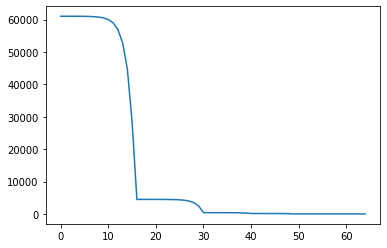

In [29]:
plt.plot(fitness_values)

The pattern search even works efficiently if we increase the size of the search space to 64-bit numbers:

In [30]:
MAX=2**32
MIN=-MAX

In [31]:
fitness_values = []
avm()

Starting at fitness 1389816063: [3740523281, 1175353608]
Current parameter: 0
Trying +1 at fitness 1389816063: [3740523282, 1175353608]
Trying -1 at fitness 1389816063: [3740523280, 1175353608]
-> [3740523280, 1175353608], direction -2, fitness 1389816062
-> [3740523278, 1175353608], direction -4, fitness 1389816060
-> [3740523274, 1175353608], direction -8, fitness 1389816056
-> [3740523266, 1175353608], direction -16, fitness 1389816048
-> [3740523250, 1175353608], direction -32, fitness 1389816032
-> [3740523218, 1175353608], direction -64, fitness 1389816000
-> [3740523154, 1175353608], direction -128, fitness 1389815936
-> [3740523026, 1175353608], direction -256, fitness 1389815808
-> [3740522770, 1175353608], direction -512, fitness 1389815552
-> [3740522258, 1175353608], direction -1024, fitness 1389815040
-> [3740521234, 1175353608], direction -2048, fitness 1389814016
-> [3740519186, 1175353608], direction -4096, fitness 1389811968
-> [3740515090, 1175353608], direction -8192

-> [2350111515, 1175353608], direction 8, fitness 595703
-> [2350111523, 1175353608], direction 16, fitness 595695
-> [2350111539, 1175353608], direction 32, fitness 595679
-> [2350111571, 1175353608], direction 64, fitness 595647
-> [2350111635, 1175353608], direction 128, fitness 595583
-> [2350111763, 1175353608], direction 256, fitness 595455
-> [2350112019, 1175353608], direction 512, fitness 595199
-> [2350112531, 1175353608], direction 1024, fitness 594687
-> [2350113555, 1175353608], direction 2048, fitness 593663
-> [2350115603, 1175353608], direction 4096, fitness 591615
-> [2350119699, 1175353608], direction 8192, fitness 587519
-> [2350127891, 1175353608], direction 16384, fitness 579327
-> [2350144275, 1175353608], direction 32768, fitness 562943
-> [2350177043, 1175353608], direction 65536, fitness 530175
-> [2350242579, 1175353608], direction 131072, fitness 464639
-> [2350373651, 1175353608], direction 262144, fitness 333567
-> [2350635795, 1175353608], direction 524288

[2350707218, 1175353608]

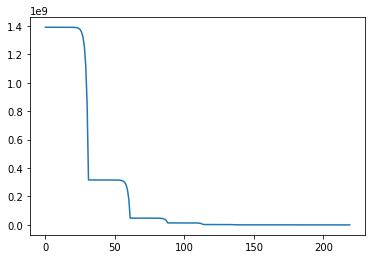

In [32]:
plt.plot(fitness_values)

## Program Instrumentation

Deriving fitness functions is not quite so easy. Of course we could come up with an equation that captures the relation between the sides of the triangle, but then essentially we would need to reproduce the entire program logic again in a function, which certainly does not help generalising to other programs. For example, consider how the fitness function would look like if the comparison was not made on the input parameters, but on values derived through computation within the function under test. Ideally, what we would want is to be able to pick a point in the program and come up with a fitness function automatically that describes how close we are to reaching this point.

There are two central ideas in order to achieve this:

- First, rather than trying to guess how close a program inputs gets to a target statement, we simply _run_ the program with the input and observe how close it actually gets.

- Second, during the execution we keep track of distance estimates like the one we calculated for the `test_me` function whenever we come across conditional statements.

In order to observe what an execution does, we need to *instrument* the program: We add new code immediately before or after the branching condition to keep track of the values observed and calculate the distance using these values.

Let's first consider what is done here conceptually. We first define a global variable in which we will store the distance, so that we can access it after the execution:

In [33]:
distance = 0

Now the instrumented version just has to update the global variable immediately before executing the branching condition:

In [34]:
def test_me_instrumented(x, y):
    global distance
    distance = abs(x - 2 * (y + 1))
    if x == 2 * (y + 1):
        return True
    else:
        return False

Let's try this out for a couple of example values:

In [35]:
test_me_instrumented(0, 0)
distance

2

In [36]:
test_me_instrumented(22, 10)
distance

0

Using this instrumented version of `test_me()`, we can define a fitness function which simply calculates the distance for the condition being true:

In [37]:
def get_fitness(individual):
    global distance
    test_me_instrumented(*individual)
    fitness = distance
    return fitness

Let's try this on some example inputs:

In [38]:
get_fitness([0, 0])

2

When we have reached the target branch, the distance will be 0:

In [39]:
get_fitness([22, 10])

0

When implementing the instrumentation, we need to consider that the branching condition may have side-effects. For example, suppose that the branching condition were `x == 2 * foo(y)`, where `foo()` is a function that takes an integer as input. Naively instrumenting would lead to the following code:

```
    distance = abs(x - 2 * foo(y))
	if x == 2 * foo(y):
	...
```

Thus, the instrumentation would lead to `foo()` being executed *twice*. Suppose `foo()` changes the state of the system (e.g., by printing something, accessing the file system, changing some state variables, etc.), then clearly invoking `foo()` a second time is a bad idea. One way to overcome this problem is to _transform_ the conditions, rather than _adding_ tracing calls. For example, one can create temporary variables that hold the values necessary for the distance calculation and then use these in the branching condition:

```
	tmp1 = x
	tmp2 = 2 * foo(y)
	distance = compute_distance(tmp1, tmp2)
	if tmp1 == tmp2:
	...
```

In [40]:
def evaluate_equals(op1, op2):
    global distance
    distance = abs(op1 - op2)
    if distance == 0:
        return True
    else:
        return False;

Now the aim would be to transform the program automatically such that it looks like so:

In [41]:
def test_me_instrumented(x, y):
    tmp1 = x
    tmp2 = 2 * (y + 1)    
    if evaluate_equals(tmp1, tmp2):
        return True
    else:
        return False

Replacing comparisons automatically is actually quite easy in Python, using the abstract syntax tree (AST) of the program. In the AST, a comparison will typically be a tree node with an operator attribute and two children for the left-hand and right-hand operators. To replace such comparisons with a call to `calculate_distance()` one simply needs to replace the comparison node in the AST with a function call node, and this is what the `BranchTransformer` class does using a NodeTransformer from Python's `ast` module:

In [42]:
import ast

In [43]:
class BranchTransformer(ast.NodeTransformer):

    def visit_FunctionDef(self, node):
        node.name = node.name + "_instrumented"
        return self.generic_visit(node)

    def visit_Compare(self, node):
        if not isinstance(node.ops[0], ast.Eq):
            return node

        return ast.Call(func=ast.Name("evaluate_equals", ast.Load()),
                        args=[node.left,
                              node.comparators[0]],
                        keywords=[],
                        starargs=None,
                        kwargs=None)

The `BranchTransformer` parses a target Python program using the built-in parser `ast.parse()`, which returns the AST. Python provides an API to traverse and modify this AST. To replace the comparison with a function call we use an `ast.NodeTransformer`, which uses the visitor pattern where there is one `visit_*` function for each type of node in the AST. As we are interested in replacing comparisons, we override `visit_Compare`, where instead of the original comparison node we return a new node of type `ast.Func`, which is a function call node. The first parameter of this node is the name of the function `calculate_distance`, and the arguments are the two operands that our `calculate_distance` function expects.

You will notice that we also override `visit_FunctionDef`; this is just to change the name of the method by appending `_instrumented`, so that we can continue to use the original function together with the instrumented one.

The following code parses the source code of the `test_me()` function to an AST, then transforms it, and prints it out again (using the `to_source()` function from the `astor` library):

In [44]:
import inspect
import ast
import astor

In [45]:
source = inspect.getsource(test_me)
node = ast.parse(source)
BranchTransformer().visit(node)

# Make sure the line numbers are ok before printing
node = ast.fix_missing_locations(node)
print(astor.to_source(node))

def test_me_instrumented(x, y):
    if evaluate_equals(x, 2 * (y + 1)):
        return True
    else:
        return False



To calculate a fitness value with the instrumented version, we need to compile the instrumented AST again, which is done using Python's `compile()` function. We then need to make the compiled function accessible, for which we first retrieve the current module from `sys.modules`, and then add the compiled code of the instrumented function to the list of functions of the current module using `exec`. After this, the `cgi_decode_instrumented()` function can be accessed.

In [46]:
import sys

In [47]:
def create_instrumented_function(f):
    source = inspect.getsource(f)
    node = ast.parse(source)
    node = BranchTransformer().visit(node)

    # Make sure the line numbers are ok so that it compiles
    node = ast.fix_missing_locations(node)

    # Compile and add the instrumented function to the current module
    current_module = sys.modules[__name__]
    code = compile(node, filename="<ast>", mode="exec")
    exec(code, current_module.__dict__)

In [48]:
create_instrumented_function(test_me)

In [49]:
test_me_instrumented(0, 0)

False

In [50]:
distance

2

In [51]:
test_me_instrumented(22, 10)

True

In [52]:
distance

0

The estimate for any relational comparison of two values is defined in terms of the _branch distance_. Our `evaluate_equals` function indeed implements the branch distance function for an equality comparison. To generalise this we need similar estimates for other types of relational comparisons. Furthermore, we also have to consider the distance to such conditions evaluating to false, not just to true. Thus, each if-condition actually has two distance estimates, one to estimate how close it is to being true, and one how close it is to being false. If the condition is true, then the true distance is 0; if the condition is false, then the false distance is 0. That is, in a comparison `a == b`, if `a` is smaller than `b`, then the false distance is `0` by definition. 

The following table shows how to calculate the distance for different types of comparisons:

| Condition | Distance True | Distance False |
| ------------- |:-------------:| -----:|
| a == b      | abs(a - b) | 1 |
| a != b      | 1          | abs(a - b) |
| a < b       | b - a + 1  | a - b      |
| a <= b      | b - a      | a - b + 1  |
| a > b       | a - b + 1  | b - a      |


Note that several of the calculations add a constant `1`. The reason for this is quite simple: Suppose we want to have `a < b` evaluate to true, and let `a = 27` and `b = 27`. The condition is not true, but simply taking the difference would give us a result of `0`. To avoid this, we have to add a constant value. It is not important whether this value is `1` -- any positive constant works.

We generalise our `evaluate_equals` function to an `evaluate_condition` function that takes the operator as an additional parameter, and then implements the above table. In contrast to the previous `calculate_equals`, we will now calculate both, the true and the false distance:

In [53]:
def evaluate_condition(op, lhs, rhs):
    distance_true = 0
    distance_false = 0
    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    # ... code for other types of conditions

    if distance_true == 0:
        return True
    else:
        return False

Let's consider a slightly larger function under test. We will use the well known triangle example, originating in Glenford Meyer's classical Art of Software Testing book 

In [54]:
def triangle(a, b, c):
    if a <= 0 or b <= 0 or c <= 0:
        return 4 # invalid
    
    if a + b <= c or a + c <= b or b + c <= a:
        return 4 # invalid
    
    if a == b and b == c:
        return 1 # equilateral
    
    if a == b or b == c or a == c:
        return 2 # isosceles
    
    return 3 # scalene

The function takes as input the length of the three sides of a triangle, and returns a number representing the type of triangle:

In [55]:
triangle(4,4,4)

1

Adapting our representation is easy, we just need to correctly set the number of parameters:

In [56]:
sig = signature(triangle)
num_parameters = len(sig.parameters)
num_parameters

3

For the `triangle` function, however, we have multiple if-conditions; we have to add instrumentation to each of these using `evaluate_condition`. We also need to generalise from our global `distance` variable, since we now have two distance values per branch, and potentially multiple branches. Furthermore, a condition might be executed multiple times within a single execution (e.g., if it is in a loop), so rather than storing all values, we will only keep the _minimum_ value observed for each condition:

In [57]:
distances_true = {}
distances_false = {}

In [58]:
def update_maps(condition_num, d_true, d_false):
    global distances_true, distances_false

    if condition_num in distances_true.keys():
        distances_true[condition_num] = min(distances_true[condition_num], d_true)
    else:
        distances_true[condition_num] = d_true

    if condition_num in distances_false.keys():
        distances_false[condition_num] = min(distances_false[condition_num], d_false)
    else:
        distances_false[condition_num] = d_false

Now we need to finish implementing the `evaluate_condition` function. We add yet another parameter to denote the ID of the branch we are instrumenting:

In [59]:
def evaluate_condition(num, op, lhs, rhs):
    distance_true = 0
    distance_false = 0

    # Make sure the distance can be calculated on number and character
    # comparisons (needed for cgi_decode later)
    if isinstance(lhs, str):
        lhs = ord(lhs)
    if isinstance(rhs, str):
        rhs = ord(rhs)

    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    elif op == "Gt":
        if lhs > rhs:
            distance_false = lhs - rhs
        else:
            distance_true = rhs - lhs + 1
    elif op == "Lt":
        if lhs < rhs:
            distance_false = rhs - lhs
        else:
            distance_true = lhs - rhs + 1
    elif op == "LtE":
        if lhs <= rhs:
            distance_false = rhs - lhs + 1
        else:
            distance_true = lhs - rhs
    # ...
    # handle other comparison operators
    # ...

    elif op == "In":
        minimum = sys.maxsize
        for elem in rhs.keys():
            distance = abs(lhs - ord(elem))
            if distance < minimum:
                minimum = distance

        distance_true = minimum
        if distance_true == 0:
            distance_false = 1
    else:
        assert False

    update_maps(num, normalise(distance_true), normalise(distance_false))

    if distance_true == 0:
        return True
    else:
        return False

We need to normalise branch distances since different comparisons will be on different scales, and this would bias the search. We will use the normalisaction function defined in the previous chapter:

In [60]:
def normalise(x):
    return x / (1.0 + x)

We also need to extend our instrumentation function to take care of all comparisons, and not just equality comparisons:

In [61]:
import ast
class BranchTransformer(ast.NodeTransformer):

    branch_num = 0

    def visit_FunctionDef(self, node):
        node.name = node.name + "_instrumented"
        return self.generic_visit(node)

    def visit_Compare(self, node):
        if node.ops[0] in [ast.Is, ast.IsNot, ast.In, ast.NotIn]:
            return node

        self.branch_num += 1
        return ast.Call(func=ast.Name("evaluate_condition", ast.Load()),
                        args=[ast.Num(self.branch_num - 1),
                              ast.Str(node.ops[0].__class__.__name__),
                              node.left,
                              node.comparators[0]],
                        keywords=[],
                        starargs=None,
                        kwargs=None)

We can now take a look at the instrumented version of `triangle`:

In [62]:
source = inspect.getsource(triangle)
node = ast.parse(source)
transformer = BranchTransformer()
transformer.visit(node)

# Make sure the line numbers are ok before printing
node = ast.fix_missing_locations(node)
print(astor.to_source(node))
num_branches = transformer.branch_num

def triangle_instrumented(a, b, c):
    if evaluate_condition(0, 'LtE', a, 0) or evaluate_condition(1, 'LtE', b, 0
        ) or evaluate_condition(2, 'LtE', c, 0):
        return 4
    if evaluate_condition(3, 'LtE', a + b, c) or evaluate_condition(4,
        'LtE', a + c, b) or evaluate_condition(5, 'LtE', b + c, a):
        return 4
    if evaluate_condition(6, 'Eq', a, b) and evaluate_condition(7, 'Eq', b, c):
        return 1
    if evaluate_condition(8, 'Eq', a, b) or evaluate_condition(9, 'Eq', b, c
        ) or evaluate_condition(10, 'Eq', a, c):
        return 2
    return 3



To define an executable version of the instrumented triangle function, we can use our `create_instrumented_function` function again:

In [63]:
create_instrumented_function(triangle)

In [64]:
triangle_instrumented(4, 4, 4)

1

In [65]:
distances_true

{0: 0.8, 1: 0.8, 2: 0.8, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.0, 7: 0.0}

In [66]:
distances_false

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.5, 7: 0.5}

The branch distance functions above are defined only for atomic comparisons. However, in the `triangle` program all of the atomic comparisons are part of larger predicates, joined together by `and` and `or` connectors. 

For conjunctions the branch distance is defined such that the distance to make `A and B` true equals the sum of the branch distances for `A` and `B`, as both of the two conditions would need to be true. Similarly, the branch distance to make `A or B` true would be the _minimum_ of the two branch distances of `A` and `B`, as it suffices if one of the two conditions is true to make the entire expression true (and the false distance would be the sum of false distances of the conditions). For a negation `not A`, we can simply switch from the true distance to the false distance, or vice versa. Since predicates can consist of nested conditions, one would need to recursively calculate the branch distance.


Assume we want to find an input that covers the third if-condition, i.e., it produces a triangle where all sides have equal length. Considering instrumented version of the triangle function we printed above, in order for this if-condition to evaluate to true we require conditions 0, 1, 2, 3, 4, and 5 to evaluate to false, and 6 and 7 to evaluate to true. Thus, the fitness function for this branch would be the sum of false distances for branches 0-5, and true distances for branches 6 and 7.

In [67]:
def get_fitness(x):
    # Reset any distance values from previous executions
    global distances_true, distances_false
    distances_true = {x: 1.0 for x in range(10)}
    distances_false = {x: 1.0 for x in range(10)}

    # Run the function under test
    triangle_instrumented(*x)

    # Sum up branch distances
    fitness = 0.0
    for branch in [6, 7]:
        fitness += distances_true[branch]

    for branch in [0, 1, 2, 3, 4, 5]:
        fitness += distances_false[branch]

    return fitness

In [68]:
get_fitness([5,5,5])

0.0

In [69]:
get_fitness(get_random_individual())

3.999999999251958

In [70]:
MAX=10000
MIN=-MAX
fitness_values = []
max_gen = 1000
hillclimbing()

Starting at fitness 7.99982400563182: [-5680, 6048, -1739]
Solution fitness after 10002 fitness evaluations: 7.999750933997509: [-4013, 6048, -1739]


[-4013, 6048, -1739]

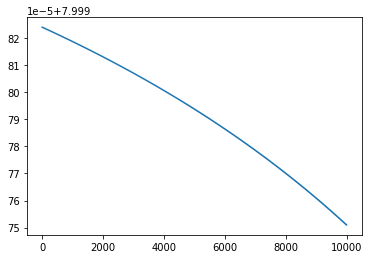

In [71]:
plt.plot(fitness_values)

In [72]:
fitness_values = []
avm()

Starting at fitness 6.995515695067264: [3784, -221, 4887]
Current parameter: 0
Trying +1 at fitness 6.995515695067264: [3785, -221, 4887]
Trying -1 at fitness 6.995515695067264: [3783, -221, 4887]
Current parameter: 1
Trying +1 at fitness 6.995515695067264: [3784, -220, 4887]
-> [3784, -220, 4887], direction 2, fitness 6.995495495495495
-> [3784, -218, 4887], direction 4, fitness 6.995454545454546
-> [3784, -214, 4887], direction 8, fitness 6.99537037037037
-> [3784, -206, 4887], direction 16, fitness 6.9951923076923075
-> [3784, -190, 4887], direction 32, fitness 6.994791666666666
-> [3784, -158, 4887], direction 64, fitness 6.99375
-> [3784, -94, 4887], direction 128, fitness 6.989583333333334
-> [3784, 34, 4887], direction 256, fitness 4.99906629318394
-> [3784, 290, 4887], direction 512, fitness 4.99877300613497
-> [3784, 802, 4887], direction 1024, fitness 4.996699669966997
-> [3784, 1826, 4887], direction 2048, fitness 1.9994895354772844
-> [3784, 3874, 4887], direction 4096, fit

[3784, 3784, 3784]

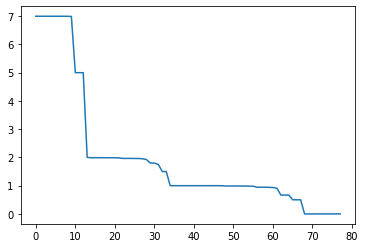

In [73]:
plt.plot(fitness_values)

Besides the local search algorithms, we can also use evolutionary search in order to find solutions to our test generation problem. We therefore need to define the usual search operators:

In [74]:
tournament_size = 3
def tournament_selection(population):
    candidates = random.sample(population, tournament_size)        
    winner = min(candidates, key=lambda x: get_fitness(x))
    return winner

In [75]:
elite_size = 2
def elitism(population):
    population.sort(key=lambda k: get_fitness(k))
    return population[:elite_size]

In [76]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = solution[:]
    for position in range(len(solution)):
        if random.random() < P_mutate:
            mutated[position] = int(random.gauss(mutated[position], 20))
    return mutated

In [77]:
def singlepoint_crossover(parent1, parent2):
    pos = random.randint(0, len(parent1))
    offspring1 = parent1[:pos] + parent2[pos:]
    offspring2 = parent2[:pos] + parent1[pos:]
    return (offspring1, offspring2)

In [78]:
population_size = 20
P_xover = 0.7
max_gen = 100
selection = tournament_selection
crossover = singlepoint_crossover
MAX=1000
MIN=-MAX

In [79]:
def ga():
    population = [get_random_individual() for _ in range(population_size)]
    best_fitness = sys.maxsize
    for p in population:
        fitness = get_fitness(p)
        if fitness < best_fitness:
            best_fitness = fitness
            best_solution = p
    print(f"Iteration 0, best fitness: {best_fitness}")

    for iteration in range(max_gen):
        fitness_values.append(best_fitness)
        new_population = elitism(population)
        while len(new_population) < len(population):
            parent1 = selection(population)
            parent2 = selection(population)

            if random.random() < P_xover:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)
            
            new_population.append(offspring1)
            new_population.append(offspring2)

        population = new_population
        for p in population:
            fitness = get_fitness(p)
            if fitness < best_fitness:
                best_fitness = fitness
                best_solution = p
        print(f"Iteration {iteration}, best fitness: {best_fitness}, size {len(best_solution)}")

    return best_solution

In [80]:
fitness_values = []
ga()

Iteration 0, best fitness: 1.9836065573770492
Iteration 0, best fitness: 1.9655172413793105, size 3
Iteration 1, best fitness: 1.875, size 3
Iteration 2, best fitness: 1.5, size 3
Iteration 3, best fitness: 1.5, size 3
Iteration 4, best fitness: 1.5, size 3
Iteration 5, best fitness: 1.5, size 3
Iteration 6, best fitness: 1.5, size 3
Iteration 7, best fitness: 1.5, size 3
Iteration 8, best fitness: 1.5, size 3
Iteration 9, best fitness: 1.5, size 3
Iteration 10, best fitness: 1.5, size 3
Iteration 11, best fitness: 1.5, size 3
Iteration 12, best fitness: 1.5, size 3
Iteration 13, best fitness: 1.5, size 3
Iteration 14, best fitness: 1.5, size 3
Iteration 15, best fitness: 1.5, size 3
Iteration 16, best fitness: 1.5, size 3
Iteration 17, best fitness: 1.5, size 3
Iteration 18, best fitness: 1.5, size 3
Iteration 19, best fitness: 0.9926470588235294, size 3
Iteration 20, best fitness: 0.9926470588235294, size 3
Iteration 21, best fitness: 0.9900990099009901, size 3
Iteration 22, best fit

[745, 745, 745]

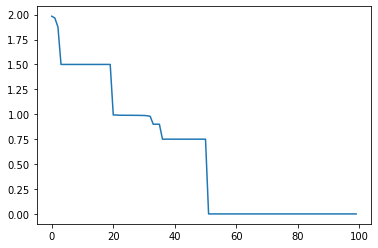

In [81]:
plt.plot(fitness_values)

We set `MAX` to a value as low as 1000, because the optimisation with our small mutational steps may take long to achieve that multiple values are equal, which some of the branches of the triangle program require (such as the one we are optimising for currently). Different mutation operators may yield different results: For example, rather than just adding random noise to the individual parameters, we can also probabilistically copy values from other parameters:

In [82]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = solution[:]
    for position in range(len(solution)):
        if random.random() < P_mutate:
            if random.random() < 0.9:
                mutated[position] = int(random.gauss(mutated[position], 20))
            else:
                mutated[position] = random.choice(solution)
    return mutated

Let's see the performance of the resulting algorithm:

In [83]:
fitness_values = []
MAX=100000
MIN=-MAX
ga()

Iteration 0, best fitness: 2.999957734573119
Iteration 0, best fitness: 2.9999577184897044, size 3
Iteration 1, best fitness: 2.999389126450825, size 3
Iteration 2, best fitness: 1.9615384615384617, size 3
Iteration 3, best fitness: 1.9230769230769231, size 3
Iteration 4, best fitness: 0.0, size 3
Iteration 5, best fitness: 0.0, size 3
Iteration 6, best fitness: 0.0, size 3
Iteration 7, best fitness: 0.0, size 3
Iteration 8, best fitness: 0.0, size 3
Iteration 9, best fitness: 0.0, size 3
Iteration 10, best fitness: 0.0, size 3
Iteration 11, best fitness: 0.0, size 3
Iteration 12, best fitness: 0.0, size 3
Iteration 13, best fitness: 0.0, size 3
Iteration 14, best fitness: 0.0, size 3
Iteration 15, best fitness: 0.0, size 3
Iteration 16, best fitness: 0.0, size 3
Iteration 17, best fitness: 0.0, size 3
Iteration 18, best fitness: 0.0, size 3
Iteration 19, best fitness: 0.0, size 3
Iteration 20, best fitness: 0.0, size 3
Iteration 21, best fitness: 0.0, size 3
Iteration 22, best fitness

[44049, 44049, 44049]

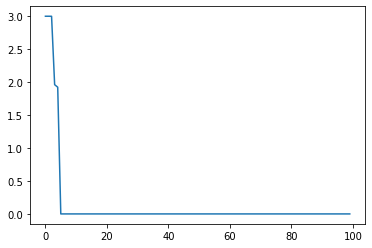

In [84]:
plt.plot(fitness_values)

In our fitness function, we manually determined which branches need to evaluate which way, and how to sum up the fitness functions. In practice, this can be automated by combining the branch distance metric with the _approach level_, which was introduced (originally named approximation level) in this paper:

Wegener, J., Baresel, A., & Sthamer, H. (2001). Evolutionary test environment for automatic structural testing. Information and software technology, 43(14), 841-854.

The approach level calculates the distances of an execution from a target node in terms of graph distances on the control dependence graph. However, we will not cover the approach level in this chapter.

## Whole Test Suite Optimisation

Besides the question of how the best fitness function for a coverage goal looks like, there are some related questions: How much time should we spend on optimising for each coverage goal? It is possible that some coverage goals are infeasible (e.g., dead code, or or infeasible branches), so any time spent on these is wasted, while it may be missing for other goals that are feasible but would need more time. Test cases typically cover multiple goals at the same time; even if a test is optimised for one specific line or branch, it may coincidentally cover others along the execution. Thus, the order in which we select coverage goals for optimisation may influence the overall result, and the number of tests we require. In principle, one way to address these issues would be by casting test generation as a multi-objective optimisation problem, and aiming to produce tests for _all_ coverage goals at the same time. However, there is an issue with this: Multi-objective algorithms like the ones we considered in the previous chapter typically work well on 2-3 objectives, but code will generally have many more coverage objectives, rendering classical multi-objective algorithms infeasible (Pareto-dominance happens rarely with higher numbers of objectives). We will therefore now consider some alternatives.

The first alternative we consider is to switch our representation: Rather than optimising individual test cases for individual coverage objectives, we optimise entire test _suites_ to cover _all_ coverage objectives at the same time. Our encoding thus should describe multiple tests. But how many? This is very much problem specific. Thus, rather than hard coding the number of tests, we will only define an upper bound, and let the search decide what is the necessary number of tests.

In [85]:
num_tests = 30

In [86]:
def get_random_individual():
    num = random.randint(1, num_tests)
    return [[random.randint(MIN, MAX) for _ in range(num_parameters)] for _ in range(num)]

When applying mutation, we need to be able to modify individual tests as before. To keep things challenging, we will not use our optimised mutation that copies parameters, but aim to achieve the entire optimisation just using small steps:

In [87]:
def mutate_test(solution):
    P_mutate = 1/len(solution)
    mutated = solution[:]
    for position in range(len(solution)):
        if random.random() < P_mutate:
            mutated[position] = int(random.gauss(mutated[position], 20))
            
    return mutated

However, modifying tests is only one of the things we can do when mutating our actual individuals, which consist of multiple tests. Besides modifying existing tests, we can also delete or add tests:

In [88]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = []
    for position in range(len(solution)):
        if random.random() >= P_mutate:
            mutated.append(solution[position][:])

    for position in range(len(mutated)):
        if random.random() < P_mutate:
            mutated[position] = mutate_test(mutated[position])

    ALPHA = 1/3
    count = 1
    while random.random() < ALPHA ** count and len(mutated) < num_tests:
        count += 1
        mutated.append([random.randint(MIN, MAX) for _ in range(num_parameters)])
    
    return mutated

With a certain probability, each of the tests can be removed from a test suite; similarly, each remaining test may be mutated like we mutated tests previously. Finally, with a probability `ALPHA` we insert a new test; if we do so, we insert another one with probability `ALPHA`$^2$, and so on.

The variable size has some knock-on effects. In particular, we need to make sure that our individuals don't grow without bounds, so we adapt the other operators accordingly. When applying crossover, we pick a relative position and then cut the individuals at their relative position, such that no offspring becomes longer than the longest parent:

In [89]:
def relative_crossover(parent1, parent2):
    pos = random.random()
    pos1 = int(len(parent1) * pos)
    pos2 = int(len(parent2) * pos)
    offspring1 = parent1[:pos1] + parent2[pos2:]
    offspring2 = parent2[:pos2] + parent1[pos1:]
    return (offspring1, offspring2)

When selecting individuals, we apply a secondary criterion: For any two individuals with equal fitness function, we prefer the shorter one:

In [90]:
tournament_size = 3
def tournament_selection(population, n=tournament_size):
    candidates = random.sample(population, n)        
    winner = min(candidates, key=lambda x: (get_fitness(x), len(x)))    
                
    return winner

The criterion also has to hold when we apply elitism -- we don't only want the test suites with the best fitness, but we also want the smallest test suites:

In [91]:
elite_size = 2
def elitism(population):
    population.sort(key=lambda k: (get_fitness(k), len(k)))
    return population[:elite_size]

Finally, the only thing that remains to be done is defining the fitness function. Since we want to cover _everything_ we simply need to make sure that every single branch is covered at least once in a test suite. A branch is covered if its minimum branch distance is 0; thus, if everything is covered, then the sum of minimal branch distances should be 0.

There is one special case: If an if-statement is executed only once, then optimising the true/false distance may lead to a suboptimal, oscillising evolution. We therefore also count how often each if-condition was executed. If it was only executed once, then the fitness value for that branch needs to be higher than if it was executed twice. For this, we extend our `update_maps` function to also keep track of the execution count:

In [92]:
condition_count = {}
def update_maps(condition_num, d_true, d_false):
    global distances_true, distances_false, condition_count

    if condition_num in condition_count.keys():
        condition_count[condition_num] = condition_count[condition_num] + 1
    else:
        condition_count[condition_num] = 1
        
    if condition_num in distances_true.keys():
        distances_true[condition_num] = min(
            distances_true[condition_num], d_true)
    else:
        distances_true[condition_num] = d_true

    if condition_num in distances_false.keys():
        distances_false[condition_num] = min(
            distances_false[condition_num], d_false)
    else:
        distances_false[condition_num] = d_false

The actual fitness function now is the sum of minimal distances after all tests have been executed. If an if-condition was not executed at all, then the true distance and the false distance will be 1, resulting in a sum of 2 for the if-condition. If the condition was covered only once, we set the fitness to exactly 1. If the condition was executed more than once, then at least either the true or false distance has to be 0, such that in sum, true and false distances will be less than 0.

In [93]:
def get_fitness(x):
    # Reset any distance values from previous executions
    global distances_true, distances_false, condition_count
    distances_true =  {x: 1.0 for x in range(num_branches)}
    distances_false = {x: 1.0 for x in range(num_branches)}
    condition_count = {x:   0 for x in range(num_branches)}

    # Run the function under test
    for test in x:
        triangle_instrumented(*test)

    # Sum up branch distances
    fitness = 0.0
    for branch in range(num_branches):
        if condition_count[branch] == 1:
            fitness += 1
        else:
            fitness += distances_true[branch]
            fitness += distances_false[branch]

    return fitness

Now we have all components in place in order to run the search.

In [94]:
max_gen=500
MAX=1000
MIN=-MAX
crossover = relative_crossover
tournament_size = 5
population_size = 50
fitness_values = []
ga()

Iteration 0, best fitness: 5.950013223661538
Iteration 0, best fitness: 5.466590534870133, size 24
Iteration 1, best fitness: 5.466590534870133, size 24
Iteration 2, best fitness: 5.398139388205614, size 25
Iteration 3, best fitness: 5.398139388205614, size 25
Iteration 4, best fitness: 5.398139388205614, size 25
Iteration 5, best fitness: 5.326710816777042, size 20
Iteration 6, best fitness: 5.294219653179191, size 20
Iteration 7, best fitness: 5.294219653179191, size 20
Iteration 8, best fitness: 5.294219653179191, size 20
Iteration 9, best fitness: 5.293377483443709, size 25
Iteration 10, best fitness: 4.794219653179191, size 21
Iteration 11, best fitness: 4.3, size 22
Iteration 12, best fitness: 4.166666666666667, size 21
Iteration 13, best fitness: 4.166666666666667, size 21
Iteration 14, best fitness: 4.166666666666667, size 21
Iteration 15, best fitness: 4.166666666666667, size 21
Iteration 16, best fitness: 4.166666666666667, size 21
Iteration 17, best fitness: 4.16666666666666

Iteration 183, best fitness: 0.0, size 16
Iteration 184, best fitness: 0.0, size 16
Iteration 185, best fitness: 0.0, size 16
Iteration 186, best fitness: 0.0, size 16
Iteration 187, best fitness: 0.0, size 16
Iteration 188, best fitness: 0.0, size 16
Iteration 189, best fitness: 0.0, size 16
Iteration 190, best fitness: 0.0, size 16
Iteration 191, best fitness: 0.0, size 16
Iteration 192, best fitness: 0.0, size 16
Iteration 193, best fitness: 0.0, size 16
Iteration 194, best fitness: 0.0, size 16
Iteration 195, best fitness: 0.0, size 16
Iteration 196, best fitness: 0.0, size 16
Iteration 197, best fitness: 0.0, size 16
Iteration 198, best fitness: 0.0, size 16
Iteration 199, best fitness: 0.0, size 16
Iteration 200, best fitness: 0.0, size 16
Iteration 201, best fitness: 0.0, size 16
Iteration 202, best fitness: 0.0, size 16
Iteration 203, best fitness: 0.0, size 16
Iteration 204, best fitness: 0.0, size 16
Iteration 205, best fitness: 0.0, size 16
Iteration 206, best fitness: 0.0, 

Iteration 379, best fitness: 0.0, size 16
Iteration 380, best fitness: 0.0, size 16
Iteration 381, best fitness: 0.0, size 16
Iteration 382, best fitness: 0.0, size 16
Iteration 383, best fitness: 0.0, size 16
Iteration 384, best fitness: 0.0, size 16
Iteration 385, best fitness: 0.0, size 16
Iteration 386, best fitness: 0.0, size 16
Iteration 387, best fitness: 0.0, size 16
Iteration 388, best fitness: 0.0, size 16
Iteration 389, best fitness: 0.0, size 16
Iteration 390, best fitness: 0.0, size 16
Iteration 391, best fitness: 0.0, size 16
Iteration 392, best fitness: 0.0, size 16
Iteration 393, best fitness: 0.0, size 16
Iteration 394, best fitness: 0.0, size 16
Iteration 395, best fitness: 0.0, size 16
Iteration 396, best fitness: 0.0, size 16
Iteration 397, best fitness: 0.0, size 16
Iteration 398, best fitness: 0.0, size 16
Iteration 399, best fitness: 0.0, size 16
Iteration 400, best fitness: 0.0, size 16
Iteration 401, best fitness: 0.0, size 16
Iteration 402, best fitness: 0.0, 

[[437, 14, 387],
 [497, 886, 47],
 [595, 22, 669],
 [982, 681, 681],
 [615, 615, 615],
 [990, 681, 648],
 [615, 615, 619],
 [619, 376, 619],
 [846, 522, 410],
 [387, 79, -450],
 [-978, 700, 41],
 [730, -294, -402],
 [319, 283, -148],
 [-370, -25, 687],
 [-826, -252, -893],
 [-633, -789, 434]]

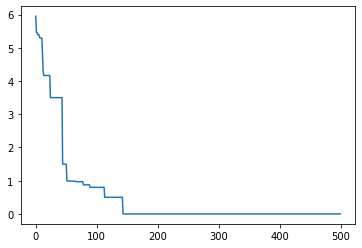

In [95]:
plt.plot(fitness_values)

There are some drawbacks to this approach: Once we have a test for a coverage goal, we are actually no longer interested in optimising tests for it (except for the case of minimising the overall test suite size). However, since we are optimising test suites, we always keep around all tests for all goals in the population. Usually, when you run whole test suite optimisation on our triangle example it will converge to cover most goals quickly except for the case of an equilateral triangle. Once it has reached that point the search needs to pick a test case to mutate that is not needed to satisfy another coverage goal, and then by chance mutate it such that the result is three equal sides. The chances of this happening are low, and the algorithm will not always produce 100% coverage unless waiting very long. We will therefore consider an improved approach next.

## Many-Objective Optimisation

Since we are attempting to evolve tests for multiple coverage goals, it would be tempting to use multi-objective optimisation algorithms. However, the MOEAs we have considered previously are all based on the central concept of domination. With increasing number of objectives, however, dominance becomes increasingly rare, and there are too many non-dominated individuals. For example, in a population of size 20 with NSGA-II, after combining the parent and offspring populations, if there are more than 20 non-dominated individuals, then Pareto sorting has no effect on parent selection, and there exists no selective pressure towards the Pareto front. Therefore, traditional MOEAs are usually only applied to problems with 2-3 objectives. Optimisation with more than 3 objectives are known as _many-objective_ optimisation problems. There are extensions of the MOEAs we have considered to the many objective scenario such as NSGA-III or Two ARchives2:

- Deb, K., & Jain, H. (2013). An evolutionary many-objective optimization algorithm using reference-point-based nondominated sorting approach, part I: solving problems with box constraints. IEEE transactions on evolutionary computation, 18(4), 577-601.

- Wang, H., Jiao, L., & Yao, X. (2014). Two_Arch2: An improved two-archive algorithm for many-objective optimization. IEEE Transactions on Evolutionary Computation, 19(4), 524-541.

However, even such many objective optimisation algorithms can only cope with only up to ~20 objectives, whereas in test generation there can be hundreds of coverage goals to optimise for.

### MOSA

The Many-Objective Sorting Algorithm (MOSA) is an extension of the NSGA-II algorithm specifically tailored 

Panichella, A., Kifetew, F. M., & Tonella, P. (2015, April). Reformulating branch coverage as a many-objective optimization problem. In 2015 IEEE 8th international conference on software testing, verification and validation (ICST) (pp. 1-10). IEEE.


MOSA is built on NSGA-II, and includes a preference criterion: Given a branch $b$, a test case $x$ is preferred over another test case $y$ if and only if the values of the distance function $f$ for $b$ satisfy the condition $f(x) < f(y)$. This preference criterion is used to distinguish between test cases within a set of non-dominated individuals.

In order to more conveniently handle the many-objective setting let's capture the notion of coverage goals explicitly (in the previous examples this was implicitly done in the fitness function, where we only considered an individual goal or the sum of all goals):

In [96]:
class Goal:
    def __init__(self, branch, value):
        self.branch = branch
        self.value  = value
    
    def get_distance(self, test):
        return test.distances[self]
    
    def is_coveredby(self, test):
        return test.distances[self] == 0
    
    def __str__(self):
        return f"Branch {self.branch}/{self.value}"

Our instrumentation gives us a number of branches, but technically, these are conditions and each condition can evaluate to true and to false, thus our coverage goals are as follows:

In [97]:
goals = [Goal(num, val) for num in range(num_branches) for val in [True, False]]

In order to avoid redundant fitness calculations, we will also use our wrapper class to cache fitness values:

In [98]:
class L(list):
    """
    A subclass of list that can accept additional attributes.
    Should be able to be used just like a regular list.
    """
    def __new__(self, *args, **kwargs):
        return super(L, self).__new__(self, args, kwargs)

    def __init__(self, *args, **kwargs):
        if len(args) == 1 and hasattr(args[0], '__iter__'):
            list.__init__(self, args[0])
        else:
            list.__init__(self, args)
        self.__dict__.update(kwargs)

    def __call__(self, **kwargs):
        self.__dict__.update(kwargs)
        return self

In the many objective scenario, we are back to optimising _test cases_ rather than test suites:

In [99]:
def get_random_individual():
    individual = L([random.randint(MIN, MAX) for _ in range(num_parameters)])
    evaluate(individual)
    return individual

In [100]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = L(solution[:])
    for position in range(len(solution)):
        if random.random() < P_mutate:
            if random.random() < 0.9:
                mutated[position] = int(random.gauss(mutated[position], 20))
            else:
                mutated[position] = random.randint(MIN, MAX)
            
    evaluate(mutated)
    return mutated

Let's also return to the regular single point crossover, since we are no longer optimising test suites, but test cases.

In [101]:
crossover = singlepoint_crossover

We will simply use the branch distance for each of the goals again (technically, this could be refined to also include the approach level). Thus, to calculate all fitness values we need to execute a test, and store the according branch distances in a map:

In [102]:
def evaluate(individual):
    global distances_true, distances_false
    distances_true =  {x: 1.0 for x in range(num_branches)}
    distances_false = {x: 1.0 for x in range(num_branches)}

    triangle_instrumented(*individual)

    individual.distances = {}
    for goal in goals:
        if goal.value:
            individual.distances[goal] = distances_true[goal.branch]
        else:
            individual.distances[goal] = distances_false[goal.branch]

There are two major differences to NSGA-II now: Rather than just using the non-dominated sorted fronts directly, MOSA first applies the preference criterion to find the tests that are preferrable for the goals not yet covered. In order to keep track of which goals have already been satisfied, MOSA uses an archive to store satisfied coverage goals with the corresponding tests.

In [103]:
def update_archive(archive, population):
    
    # Ignores secondary criterion because length is fixed here
    for test in population:
        for goal in goals:
            if goal in archive:
                continue
            if goal.is_coveredby(test):
                archive[goal] = L(test[:])
                print(f"Covered goal {goal}: {test}")

The MOSA algorithm is a variation of NSGA-II. We thus need to define the regular notion of dominance, adapted to our setting with `Goals`. In contrast to NSGA-II, however, the dominance relation only looks at uncovered goals. For this, we use our archive:

In [104]:
def dominates(solution1, solution2, archive):
    for goal in goals:
        if goal in archive:
            continue # Already covered
            
        if solution1.distances[goal] > solution2.distances[goal]:
            return False

    for goal in goals:
        if goal in archive:
            continue # Already covered

        if solution1.distances[goal] < solution2.distances[goal]:
            return True

    return False

Using the dominance relation, we can apply the fast non-dominated sort algorithm we already know from NSGA-II in order to sort a population into fronts. Again we only consider uncovered goals as defined by the archive:

In [105]:
def fast_non_dominated_sort(solutions, archive):
    front = [[]]

    S = [[] for _ in range(len(solutions))]
    n = [0 for _ in range(len(solutions))]

    for p in range(len(solutions)):
        S[p] = []
        n[p] = 0
        for q in range(len(solutions)):
            if dominates(solutions[p], solutions[q], archive):
                S[p].append(q)
            elif dominates(solutions[q], solutions[p], archive):
                n[p] = n[p] + 1

        if n[p] == 0:
            front[0].append(p)
            solutions[p].rank = 0

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] = n[q] - 1
                if n[q] == 0:
                    Q.append(q)
                    solutions[q].rank = i + 1
        i = i + 1
        front.append(Q)

    del front[len(front) - 1]
    return front

As the archive can tell us which goals are covered and which are not, the prefernce sorting can focus on those individuals that are not covered yet. For each uncovered goal, the best individual is put into a special first front. All other individuals are sorted according to regular non-dominated sorting:

In [106]:
def preference_sorting(population, archive):
    # First front consists of best test per branch
    
    fronts = []
    f0 = []
    uncovered_branches = []
    # Only consider uncovered branches
    for goal in goals:
        if goal not in archive:
            best = min(population, key=lambda t: goal.get_distance(t))
            if best not in f0:
                f0.append(best)

    for t in f0:
        t.rank = 0
    
    fronts.append(f0)
    
    remaining = [x for x in population if not x in f0]
    
    # Remaining tests: 
    if remaining:
        # Calculate non-dominance only using uncovered branches
        remaining_fronts = fast_non_dominated_sort(remaining, archive)
        for i in range(len(remaining_fronts)):
            front = [remaining[index] for index in remaining_fronts[i]]
            for t in front:
                t.rank = i + 1
            fronts.append(front)
    
    return fronts

The sorting of individuals within a front based on their crowding distance is the same we used previously, and only has to be adapted to consider our `Goal` implementation:

In [107]:
def calculate_crowding_distance_and_sort(front, archive):

    if not front:
        return
    distance = [0 for _ in range(0,len(front))]

    for goal in goals:
        if goal in archive:
            continue # Already covered

        data = [(x, front[x].distances[goal]) for x in range(len(front))]
        sorted_front = sorted(data, key=lambda tup: tup[1])
        range_fitness = sorted_front[-1][1] - sorted_front[0][1]
        if range_fitness > 0.0:
            distance[sorted_front[0][0]] = sys.maxsize
            distance[sorted_front[-1][0]] = sys.maxsize

            for k in range(1,len(front)-1):
                index = sorted_front[k][0]
                distance[index] = distance[index] + (sorted_front[k+1][1] - sorted_front[k-1][1]) / range_fitness

    for k in range(0, len(front)):
        front[k].distance = distance[k]

    front.sort(key = lambda i: i.distance, reverse=True)

Since we now have ranks based on preference sorting and we have a crowding distance, we can use the binary rank tournament selection operator we already know from NSGA-II:

In [108]:
def binary_rank_tournament(population):
    individual1 = random.choice(population)
    individual2 = random.choice(population)

    if individual1.rank < individual2.rank:
        return individual1
    elif individual1.rank > individual2.rank:
        return individual2
    else:
        return max([individual1, individual2], key = lambda i: i.distance)

Using the selection operator, we can also breed new generations:

In [109]:
def generate_offspring(population):
    offspring_population = []
    while len(offspring_population) < len(population):
        parent1 = binary_rank_tournament(population)
        parent2 = binary_rank_tournament(population)
        if random.random() < P_xover:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2
            
        offspring1 = mutate(offspring1)
        offspring2 = mutate(offspring2)

        offspring_population.append(offspring1)
        offspring_population.append(offspring2)

    return offspring_population

We also need to derive the initial population:

In [110]:
def get_initial_population(archive):
    population = [get_random_individual() for _ in range(population_size)]
    update_archive(archive, population)
    fronts = preference_sorting(population, archive)
    for front in fronts:
        calculate_crowding_distance_and_sort(front, archive)

    return population

Now we have all components in place and can implement the actual algorithm, which only slightly differs from NSGA-II. The final solution are the contents of the archive.

In [111]:
def mosa():
    archive = {}
    population = get_initial_population(archive)
    update_archive(archive, population)
    preference_sorting(population, archive)


    for iteration in range(max_gen):
        uncovered = 0
        for goal in goals:
            if not goal in archive:
                uncovered += 1

        if uncovered > 0:
            print(f"Iteration {iteration}, missing goals: {uncovered}")

        offspring_population = generate_offspring(population)
        combined = population + offspring_population
        
        fronts = preference_sorting(combined, archive)
        population = []

        for front in fronts:
            calculate_crowding_distance_and_sort(front, archive)

            for t in front:
                population.append(t)
                if len(population) == population_size:
                    break
            if len(population) == population_size:
                break

        update_archive(archive, population)
        

    return archive

In [112]:
max_gen=500
MAX=10000
MIN=-MAX
result = mosa()
print(f"Covered {len(result)} out of {len(goals)} goals")
for goal, test in result.items():
    print(f"Goal {goal}: {test}")

Covered goal Branch 0/True: [-1339, 2690, -3765]
Covered goal Branch 0/False: [9039, 3366, -3028]
Covered goal Branch 1/False: [9039, 3366, -3028]
Covered goal Branch 2/True: [9039, 3366, -3028]
Covered goal Branch 1/True: [6170, -5063, 850]
Covered goal Branch 2/False: [2565, 2185, 7269]
Covered goal Branch 3/True: [2565, 2185, 7269]
Covered goal Branch 3/False: [530, 5220, 236]
Covered goal Branch 4/True: [530, 5220, 236]
Covered goal Branch 4/False: [9063, 2349, 840]
Covered goal Branch 5/True: [9063, 2349, 840]
Covered goal Branch 5/False: [4625, 6020, 4859]
Covered goal Branch 6/False: [4625, 6020, 4859]
Covered goal Branch 8/False: [4625, 6020, 4859]
Covered goal Branch 9/False: [4625, 6020, 4859]
Covered goal Branch 10/False: [4625, 6020, 4859]
Iteration 0, missing goals: 6
Iteration 1, missing goals: 6
Iteration 2, missing goals: 6
Iteration 3, missing goals: 6
Iteration 4, missing goals: 6
Iteration 5, missing goals: 6
Iteration 6, missing goals: 6
Iteration 7, missing goals: 

### MIO

The Many Independent Objective search algorithm (MIO) addresses the problem that in test generation the number of objectives can be very large, and even with MOSA it will likely not be possible to achieve 100% coverage. Instead, the search tries to focus on those goals that are most promising, given the resources available.

Arcuri, A. (2017, September). Many independent objective (MIO) algorithm for test suite generation. In International symposium on search based software engineering (pp. 3-17). Springer, Cham.


The MIO algorithm is based on a simple (1+1)EA and maintains an archive of tests. In the archive, for each coverage goal there is a population of $n$ tests. Thus, for $z$ coverage goals there can be up to $n×z$ tests in the archive
at the same time. The archive is initially empty, and the first individual is generated randomly. Once there are tests in the archive, MIO probabilistically either samples a new random test, or chooses a test from the archive and mutates a copy of it. For each new/mutated test the fitness is calculated, and the test is added to the archive if needed.

Updating the archive with a test is based a heuristic function that is calculated for each coverage goal. If a goal is covered by a new test, then the archive for that test is replaced with that individual test. If the goal is already covered, then the existing covering test is only replaced if it is better in some other dimension (e.g. size, although that does not apply in or scenario). If the heuristic value is the worst possible value (e.g., the relevant branch predicate is not executed at all and there is no branch distance), then that test is not a candidate for the archive of that goal; else, the test is added to the archive for that goal if the maximum number of tests in that archive has not exceeded a maximum size. If the maximum size is reached, then the new test replaces the worst test in the archive, if it has a better heuristic value.

In [113]:
archive_size = 10
def update_mio_archive(archive, t):
    for goal in goals:
        if goal in archive and len(archive[goal]) == 1 and goal.is_coveredby(archive[goal][0]):
            # Goal is already covered
            continue
        h = goal.get_distance(t)
        if h == 0:
            # Keep only that test, remove all others            
            print(f"Goal {goal} covered by {t}")
            archive[goal] = [t]

        elif h < 1:
            if goal not in archive:
                archive[goal] = [t]
            elif len(archive[goal]) < archive_size and not t in archive[goal]:
                archive[goal].append(t)
            elif h < goal.get_distance(archive[goal][-1]):
                # Replace worst, if this one is better
                del archive[goal][-1]
                archive[goal].append(t)
                
            archive[goal].sort(key = lambda t: goal.get_distance(t))

When sampling a test from the archive in order to produce a new offspring, the algorithm first randomly selects an uncovered goal, and then randomly selects a test for that goal from the archive. If the archive contains no tests for uncovered goals, then it randomly selects a covered goal and uses that test.

In [114]:
def sample_archive(archive):
    uncovered_goals = []
    for goal, tests in archive.items():
        if len(tests) == 1 and goal.is_coveredby(tests[0]):
            continue
        elif len(tests) > 0:
            uncovered_goals.append(goal)
            
    if not uncovered_goals:
        for goal, tests in archive.items():
            if len(tests) > 0:
                uncovered_goals.append(goal)
                
    goal = random.choice(uncovered_goals)
    
    # Now choose one test randomly for "goal" in archive
    return random.choice(archive[goal])

As a further improvement of the sampling process, MIO implements feedback directed sampling: The idea is that goals for which we recently achieved an improvement should be preferred, since there is potential to reach a test there, whereas goals for which no improvement has recently been achieved are either difficult or infeasible, and should thus be postponed until the easier targets have been covered. To achieve this, we add a `sample_counter` which counts how often sampling was applied to each goal. Whenever a new test for a goal is added to the archive, the counter is reset to 0. Then, we can rank the goals by their counter, and choose the goal with the lowest counter. To integrate the counter, we need to update our `update_archive` function. While making this change, we also keep track if the archive has been changed, which we will need later:

In [115]:
sample_counter = {}

In [116]:
archive_size = 10
def update_mio_archive(archive, t):
    updated = False
    for goal in goals:
        if goal in archive and len(archive[goal]) == 1 and goal.is_coveredby(archive[goal][0]):
            # Goal is already covered
            continue
        h = goal.get_distance(t)
        if h == 0:
            # Keep only that test, remove all others            
            print(f"Goal {goal} covered by {t}")
            sample_counter[goal] = 0
            archive[goal] = [t]
            updated = True

        elif h < 1:
            if goal not in archive:
                sample_counter[goal] = 0
                archive[goal] = [t]
                updated = True
            elif len(archive[goal]) < archive_size and not t in archive[goal]:
                sample_counter[goal] = 0
                updated = True
                archive[goal].append(t)
            elif h < goal.get_distance(archive[goal][-1]):
                # Replace worst, if this one is better
                del archive[goal][-1]
                sample_counter[goal] = 0
                archive[goal].append(t)
                updated = True
                
            archive[goal].sort(key = lambda t: goal.get_distance(t))
            
    return updated

Accordingly, we can now update the sampling method to consider the counter:

In [117]:
def sample_archive(archive):
    uncovered_goals = []    
    for goal, tests in archive.items():
        if len(tests) == 1 and goal.is_coveredby(tests[0]):
            continue
        elif len(tests) > 0:
            uncovered_goals.append(goal)
            
    if not uncovered_goals:        
        for goal, tests in archive.items():            
            if len(tests) > 0:
                uncovered_goals.append(goal)
    
    # Shuffle first such that in the case of ties
    # we still have some variation
    random.shuffle(uncovered_goals)
    uncovered_goals.sort(key = lambda g: sample_counter[g])

    goal = uncovered_goals[0]
    sample_counter[goal] += 1
    
    # Now choose one test randomly for "goal" in archive
    return random.choice(archive[goal])

At the end of the search, for each goal which has exactly one test in the archive and that test covers the goal, this test is part of the resulting test suite:

In [118]:
def get_solutions(archive):
    test_suite = {}
    for goal, tests in archive.items():
        if len(tests) == 1 and goal.is_coveredby(tests[0]):
            test_suite[goal] = tests[0]
    return test_suite

The algorithm itself is now very simple:

In [119]:
P_sample = 0.5

def mio():
    archive = {}
    
    for step in range(max_gen * population_size):
        if random.random() < P_sample or len(archive) == 0:
            current = get_random_individual()
        else:
            current = sample_archive(archive)
            current = mutate(current)

        update_mio_archive(archive, current)
        
    return get_solutions(archive)
    

In [120]:
sample_counter = {}
result = mio()
print(f"Covered {len(result)}/{len(goals)} goals")
for goal, test in result.items():
    print(f"Goal {goal}: {test}")

Goal Branch 0/True covered by [-437, -8562, 3201]
Goal Branch 0/False covered by [7129, -4185, -6296]
Goal Branch 1/True covered by [7129, -4185, -6296]
Goal Branch 1/False covered by [7776, 6561, -1165]
Goal Branch 2/True covered by [7776, 6561, -1165]
Goal Branch 2/False covered by [332, 5153, 3193]
Goal Branch 3/False covered by [332, 5153, 3193]
Goal Branch 4/True covered by [332, 5153, 3193]
Goal Branch 3/True covered by [1218, 3216, 4543]
Goal Branch 4/False covered by [9494, 6787, 4119]
Goal Branch 5/False covered by [9494, 6787, 4119]
Goal Branch 6/False covered by [9494, 6787, 4119]
Goal Branch 8/False covered by [9494, 6787, 4119]
Goal Branch 9/False covered by [9494, 6787, 4119]
Goal Branch 10/False covered by [9494, 6787, 4119]
Goal Branch 5/True covered by [8900, 3754, 4811]
Goal Branch 6/True covered by [9559, 9559, 4222]
Goal Branch 7/False covered by [9559, 9559, 4222]
Goal Branch 8/True covered by [9559, 9559, 4222]
Goal Branch 10/True covered by [4961, 443, 4961]
Goal

As a further refinement, MIO can take into account that, during initial phases of the search more exploration is generally needed, while later phases should focus on exploitation. More exploration means that the probability of sampling a new, random test should be higher, while focusing on exploitation would reduce that probability and focus on improving fewer existing individuals, thus also reducing the archive size. MIO therefore defines two sets of parameters: The probability of sampling new tests, the size of the archive, and the number of mutations applied to the same individual with their initial values, and their values once the focused phase begins:

In [121]:
P_sample_focused = 0
P_sample_first = 0.5

archive_size_focused = 1
archive_size_first = 10

mutations_focused = 10
mutations_first = 1

# Percentage of search budget spent when focused phase should begin
F = 0.5

From the initial phase to the beginning of the focused phase, the parameters are gradually moved towards their focused values:

In [122]:
focused = False
def update_parameters(steps, archive):
    global focused, P_sample, archive_size, num_mutations, F
    progress = steps / (max_gen * population_size)
    progress_until_focused = progress / F;
    if progress > F:
        P_sample = P_sample_focused
        archive_size = archive_size_focused
        num_mutations = mutations_focused
        if not focused:
            print(f"Entering focused phase")
            focused = True
    else:
        pps = P_sample
        pas = archive_size
        pnm = num_mutations
        
        P_sample = P_sample_first + (P_sample_focused - P_sample_first) * progress_until_focused
        archive_size = int(archive_size_first + (archive_size_focused - archive_size_first) * progress_until_focused)
        num_mutations = int(mutations_first + (mutations_focused - mutations_first) * progress_until_focused)
        
        if pas != archive_size:
            # Crop archives if necessary
            for goal in goals:
                if goal in archive:
                    while len(archive[goal]) > archive_size:
                        # Delete worst
                        del archive[goal][-1]

The updated MIO algorithm needs to update the parameters, and also consider the case that the current individual can be mutated multiple times:

In [123]:
import copy
P_sample = 0.7
archive_size = 10
num_mutations = 1
F = 0.5
def mio():
    sample_counter = {}
    archive = {}
    update_parameters(0, archive)
    current_mutations = 0
    current = None
    
    for step in range(max_gen * population_size):
        if current and current_mutations < num_mutations:
            offspring = mutate(current)
            current_mutations += 1
        elif random.random() < P_sample or len(archive) == 0:
            offspring = get_random_individual()
            current_mutations = 1
        else:
            offspring = sample_archive(archive)
            offspring = mutate(offspring)
            current_mutations = 1

        update_parameters(step, archive)
        result = update_mio_archive(archive, offspring)
        if result:
            current = copy.deepcopy(offspring)
        
    return get_solutions(archive)

In [124]:
sample_counter = {}
focused = False
result = mio()
print(f"Covered {len(result)}/{len(goals)} goals")
for goal, test in result.items():
    print(f"Goal {goal}: {test}")

Goal Branch 0/True covered by [-3464, 8698, 7505]
Goal Branch 0/False covered by [5302, -298, 7915]
Goal Branch 1/True covered by [5302, -298, 7915]
Goal Branch 1/False covered by [8134, 6535, -859]
Goal Branch 2/True covered by [8134, 6535, -859]
Goal Branch 2/False covered by [4844, 7152, 2147]
Goal Branch 3/False covered by [4844, 7152, 2147]
Goal Branch 4/True covered by [4844, 7152, 2147]
Goal Branch 4/False covered by [6110, 3639, 1629]
Goal Branch 5/True covered by [6110, 3639, 1629]
Goal Branch 5/False covered by [9173, 9545, 7296]
Goal Branch 6/False covered by [9173, 9545, 7296]
Goal Branch 8/False covered by [9173, 9545, 7296]
Goal Branch 9/False covered by [9173, 9545, 7296]
Goal Branch 10/False covered by [9173, 9545, 7296]
Goal Branch 3/True covered by [2231, 2306, 8116]
Goal Branch 6/True covered by [7479, 7479, 1948]
Goal Branch 7/False covered by [7479, 7479, 1948]
Goal Branch 8/True covered by [7479, 7479, 1948]
Goal Branch 10/True covered by [6187, 4118, 6187]
Goal B

### Evaluation

The hypervolume is less suitable to evaluate the results of these algorithms -- in MIO we don't have an explicit Pareto front, and even though in MOSA we do have a first front, test cases that do not quite cover a coverage goal are of no practical use. The metric we therefore consider is the number of coverage goals satisfied. For our implementations of MIO and MOSA we can see this number from the number of tests in a test suite.

In [125]:
from IPython.utils import io

def run_times(algorithm, repetitions):
    global fitness_values, diversity_values, ims
    result = []
    for i in range(repetitions):
        with io.capture_output() as captured: 
            testsuite = algorithm()
        result.append(len(testsuite) / len(goals))
    return result

Let's increase the difficulty of the search problem somewhat so we can actually see some differences:

In [126]:
MAX=1000000
MIN=-MAX

[Text(1, 0, 'MIO'), Text(2, 0, 'MOSA')]

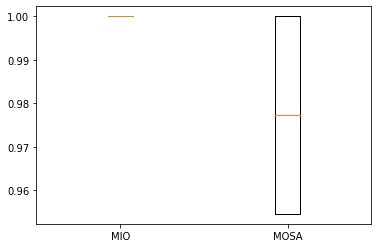

In [127]:
results = {"MIO"  : run_times(mio, 10), 
           "MOSA" : run_times(mosa, 10)}
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())

### Variable Length Tests

The `cgi_decode()` function originates in the book _Pezzè, M., & Young, M. (2008). Software testing and analysis: process, principles, and techniques. John Wiley & Sons._, and we will use the Python implementation used in the [Fuzzingbook](https://www.fuzzingbook.org/). It takes as input a string using the CGI encoding common for HTTP-Get queries, and returns a decoded string.

In [128]:
def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t

As usual, we can apply the source transformation to calculate our branch distances and determine the total number of goals:

In [129]:
source = inspect.getsource(cgi_decode)
node = ast.parse(source)
transformer = BranchTransformer()
transformer.visit(node)
node = ast.fix_missing_locations(node)
num_branches = transformer.branch_num
print(astor.to_source(node))

def cgi_decode_instrumented(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""
    hex_values = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6,
        '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14,
        'f': 15, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15}
    t = ''
    i = 0
    while evaluate_condition(0, 'Lt', i, len(s)):
        c = s[i]
        if evaluate_condition(1, 'Eq', c, '+'):
            t += ' '
        elif evaluate_condition(2, 'Eq', c, '%'):
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if evaluate_condition(3, 'In', digit_high, hex_values
                ) and evaluate_condition(4, 'In', digit_low, hex_values):
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:


In [130]:
create_instrumented_function(cgi_decode)

In [131]:
goals = [Goal(num, val) for num in range(num_branches) for val in [True, False]]
len(goals)

10

In order to apply search to this problem, we first need to update our `evaluate` function so that it calls `cgi_decoded_instrumented`. We also need to take into account that calling the function may throw an exception:

In [132]:
def evaluate(individual):
    global distances_true, distances_false
    distances_true =  {x: 1.0 for x in range(num_branches)}
    distances_false = {x: 1.0 for x in range(num_branches)}

    try:
        cgi_decode_instrumented(''.join(individual))
    except:
        pass

    individual.distances = {}
    for goal in goals:
        if goal.value:
            individual.distances[goal] = distances_true[goal.branch]
        else:
            individual.distances[goal] = distances_false[goal.branch]

Now we need to decide on a representation. A simple way to encode strings is as a list of characters; this way, we don't need to make many changes to our existing operators. As another modification, we restrict the range to printable characters. However, what length should we use for our tests? If we fix the length, then we might end up with redundantly long strings. Therefore, let's use a variable size representation:

In [133]:
string_length = 10
def get_random_individual():
    s = []
    length = random.randint(1, string_length)
    for i in range(string_length):
        s.append(chr(random.randrange(32, 127)))
    individual = L(s)

    evaluate(individual)
    return individual

In [134]:
def mutate(solution):
    P_mutate = 1/len(solution) if solution else 0
    result = []
    for position in range(len(solution)):
        if random.random() > P_mutate:
            result.append(solution[position])
    for position in range(len(result)):
        if random.random() < P_mutate:
            result[position] = chr(int(random.gauss(ord(result[position]), 100) % 65536))
    ALPHA = 0.1
    count = 1
    while random.random() < ALPHA ** count and len(result) < string_length:
        count += 1
        pos = random.randint(0, len(result))
        result.insert(pos, chr(random.randrange(32, 127)))
            
    mutated = L(result)
    evaluate(mutated)
    return mutated

MOSA and MIO both allow for secondary optimisation criteria: If we have already covered a test goal but have now found a new test that is shorter, we can replace the existing test in the archive. We thus need to update the archive updating functions of both algorithms to take this into account:

In [135]:
def update_archive(archive, population):
    
    for test in population:
        for goal in goals:
            if goal.is_coveredby(test):
                if not goal in archive or len(test) < len(archive[goal]):
                    archive[goal] = L(test[:])
                    print(f"Covered goal {goal}: {test}")

In [136]:
def update_mio_archive(archive, t):
    updated = False
    for goal in goals:
        h = goal.get_distance(t)
        if h == 0:
            if not goal in archive or not goal.is_coveredby(archive[goal][0]):
                print(f"Goal {goal} covered by {t}: {goal in archive}")
                sample_counter[goal] = 0
                archive[goal] = [t]
                updated = True
            elif goal.is_coveredby(archive[goal][0]):
                # Goal is already covered
                if len(t) < len(archive[goal][0]):
                    sample_counter[goal] = 0
                    archive[goal] = [t]
                    updated = True

        elif h < 1:
            if goal in archive and len(archive[goal]) == 1 and goal.is_coveredby(archive[goal][0]):
                # Goal is already covered
                continue
            if goal not in archive:
                sample_counter[goal] = 0
                archive[goal] = [t]
                updated = True
            elif len(archive[goal]) < archive_size and not t in archive[goal]:
                sample_counter[goal] = 0
                updated = True
                archive[goal].append(t)
            elif h < goal.get_distance(archive[goal][-1]):
                # Replace worst, if this one is better
                del archive[goal][-1]
                sample_counter[goal] = 0
                archive[goal].append(t)
                updated = True
                
            archive[goal].sort(key = lambda t: goal.get_distance(t))
            
    return updated

Without any further changes, we can now apply MOSA and MIO on this test generation problem:

In [137]:
result = mio()
print(len(result))
for goal, test in result.items():
    print(f"Goal {goal}: {''.join(test)}")

Goal Branch 0/True covered by [',', 'K', 'L', '"', "'", 'q', '|', 'K', 'g', 'D']: False
Goal Branch 0/False covered by [',', 'K', 'L', '"', "'", 'q', '|', 'K', 'g', 'D']: False
Goal Branch 1/False covered by [',', 'K', 'L', '"', "'", 'q', '|', 'K', 'g', 'D']: False
Goal Branch 2/False covered by [',', 'K', 'L', '"', "'", 'q', '|', 'K', 'g', 'D']: False
Goal Branch 1/True covered by ['N', 'C', 'Q', '}', ']', '(', '{', '.', '+', 'U']: True
Goal Branch 2/True covered by ['m', 'E', '7', 'Z', '%', 'L', 'O', '`', '9', 'G']: True
Goal Branch 3/False covered by ['m', 'E', '7', 'Z', '%', 'L', 'O', '`', '9', 'G']: False
Goal Branch 3/True covered by ['B', '%', 'B', '?', 'r', '`', 'T', '?', 'I', '1']: True
Goal Branch 4/False covered by ['B', '%', 'B', '?', 'r', '`', 'T', '?', 'I', '1']: False
Goal Branch 4/True covered by ['%', 'B', '1']: True
10
Goal Branch 0/True: B
Goal Branch 0/False: 
Goal Branch 1/True: +
Goal Branch 1/False: B
Goal Branch 2/True: %
Goal Branch 2/False: B
Goal Branch 3/Tru

In [138]:
result = mosa()
print(len(result))
for goal, test in result.items():
    print(f"Goal {goal}: {''.join(test)}")

Covered goal Branch 0/True: ['B', 'S', '#', 'r', 'i', '-', '}', 'h', 'c', 'U']
Covered goal Branch 0/False: ['B', 'S', '#', 'r', 'i', '-', '}', 'h', 'c', 'U']
Covered goal Branch 1/False: ['B', 'S', '#', 'r', 'i', '-', '}', 'h', 'c', 'U']
Covered goal Branch 2/False: ['B', 'S', '#', 'r', 'i', '-', '}', 'h', 'c', 'U']
Covered goal Branch 2/True: ['%', 'M', '~', 'W', 'l', '!', 'v', 'U', '{', '/']
Covered goal Branch 3/False: ['%', 'M', '~', 'W', 'l', '!', 'v', 'U', '{', '/']
Covered goal Branch 1/True: ['W', '8', '+', 'k', 'l', 'Q', '`', 'J', 'h', 'w']
Covered goal Branch 3/True: [' ', '8', 'N', ' ', '+', '1', 'e', '%', '5', '<']
Covered goal Branch 4/False: [' ', '8', 'N', ' ', '+', '1', 'e', '%', '5', '<']
Iteration 0, missing goals: 1
Covered goal Branch 0/True: [' ', '8', 'N', '+', '1', 'e', '%', '5', '<']
Covered goal Branch 1/True: [' ', '8', 'N', '+', '1', 'e', '%', '5', '<']
Covered goal Branch 1/False: [' ', '8', 'N', '+', '1', 'e', '%', '5', '<']
Covered goal Branch 2/True: [' 

In the final test suites, there should be tests containing the character `+`, there should be invalid hex codes, valid hexcodes, and some non-escaped characters. There will be some redundancy in the overall test suite: The same test may cover multiple goals. Minimising the final test suite further, however, is another optimisation problem.